# Time-Series Analysis and Modeling of Microsoft Stock

### **Table of Contents**
* [<span style="color:#A690A4"> 0. Executive Summary](#exe_sum)
* [<span style="color:#A690A4"> 1. Introduction](#intro)
* [<span style="color:#A690A4"> 2. Collect, Wrangle & Explore Data](#process)
* [<span style="color:#A690A4"> 3. Predict Microsoft Stock](#predict)
* [<span style="color:#A690A4"> 4. Conclusion](#conclusion)

# <span style="color:#5E6997">Executive Summary</span> <a class="anchor" id="exe_sum"></a>

# <span style="color:#5E6997">Introduction</span> <a class="anchor" id="intro"></a>

# <span style="color:#5E6997">Collect, Wrangle, and Explore Data</span> <a class="anchor" id="process"></a>

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [18]:
import pandas as pd

# Load the data
df = pd.read_csv('./Microsoft_Stock.csv', parse_dates=['Date'])
# df = pd.read_csv('/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv', parse_dates=['Date'])

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Display the first few rows
print(df.head())


                      Open   High    Low  Close    Volume
Date                                                     
2015-04-01 16:00:00  40.60  40.76  40.31  40.72  36865322
2015-04-02 16:00:00  40.66  40.74  40.12  40.29  37487476
2015-04-06 16:00:00  40.34  41.78  40.18  41.55  39223692
2015-04-07 16:00:00  41.61  41.91  41.31  41.53  28809375
2015-04-08 16:00:00  41.48  41.69  41.04  41.42  24753438


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [20]:
# 1. compute min/max for all numeric columns
summary = df.agg(['min', 'max'])

# 2. grab the min/max of the Date index
min_date, max_date = df.index.min(), df.index.max()

# 3. add them into the summary as a new column
summary['Date'] = [min_date, max_date]

print(summary)


       Open    High     Low   Close     Volume                Date
min   40.34   40.74   39.72   40.29     101612 2015-04-01 16:00:00
max  245.03  246.13  242.92  244.99  135227059 2021-03-31 16:00:00


## Graphical Analysis

### Line chart of closing prices

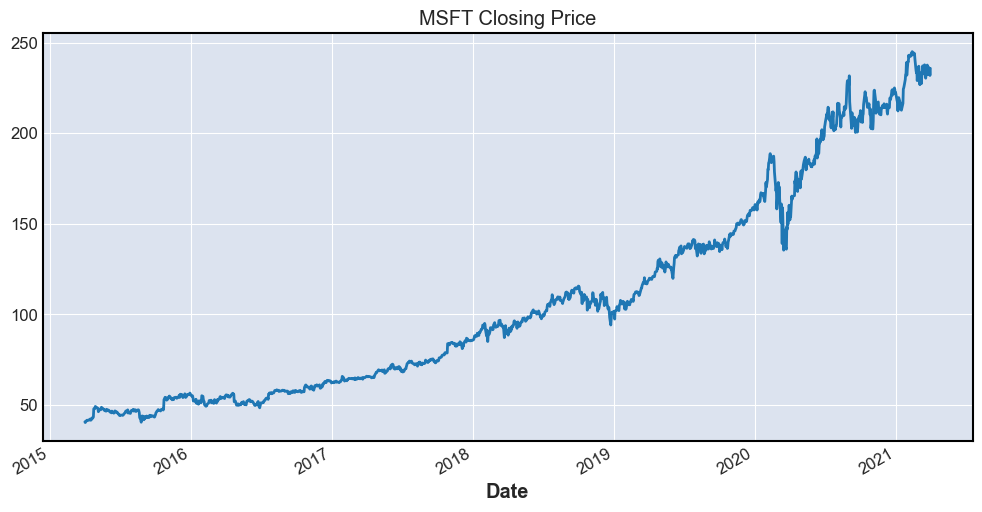

In [21]:
ax = df['Close'].plot(figsize=(12,6), title="MSFT Closing Price")
ax.get_figure().savefig("images/msft_closing_price.png", dpi=300)

#### Observations

When I look at the closing‐price line from 2015 through early 2021, I see a pronounced upward trend punctuated by a sharp drawdown around March 2020 (COVID crash). The non-linear, accelerating growth tells me the series is clearly non‐stationary—if I tried to fit an ARIMA directly to prices, I’d violate its stationarity assumption. Next step: I’ll transform to log‐returns or first differences to remove the trend before fitting any model that assumes constant mean and variance.

### Candlestick (OHLC) chart

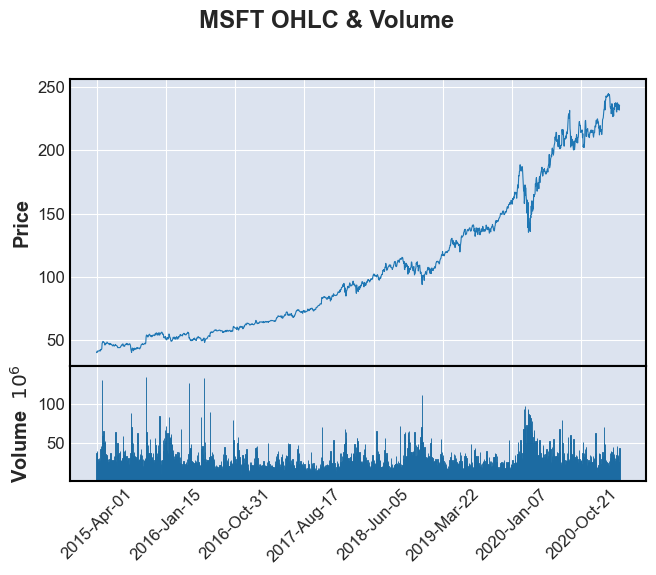

In [22]:
import matplotlib.pyplot as plt
import mplfinance as mpf

# if your index is currently dates (or strings), coerce it back into a DatetimeIndex
df.index = pd.to_datetime(df.index)

# draw the figure and get back the Figure object
fig, axes = mpf.plot(
    df,
    type='line',
    volume=True,
    title="MSFT OHLC & Volume",
    returnfig=True
)

# now save it 
fig.savefig("images/msft_ohlc_volume.png", dpi=300, bbox_inches='tight')

# display
plt.show()


#### Observations

Overlaying volume shows that the biggest price swings (especially the March 2020 plunge) coincide with massive spikes in trading activity. This co‐movement suggests volume carries information about market stress and could improve forecasts. Next step: I’ll consider including volume as an exogenous regressor (e.g. in VARX) or use it to define volatility regimes (e.g. a threshold in a regime‐switching GARCH).

### Moving Averages

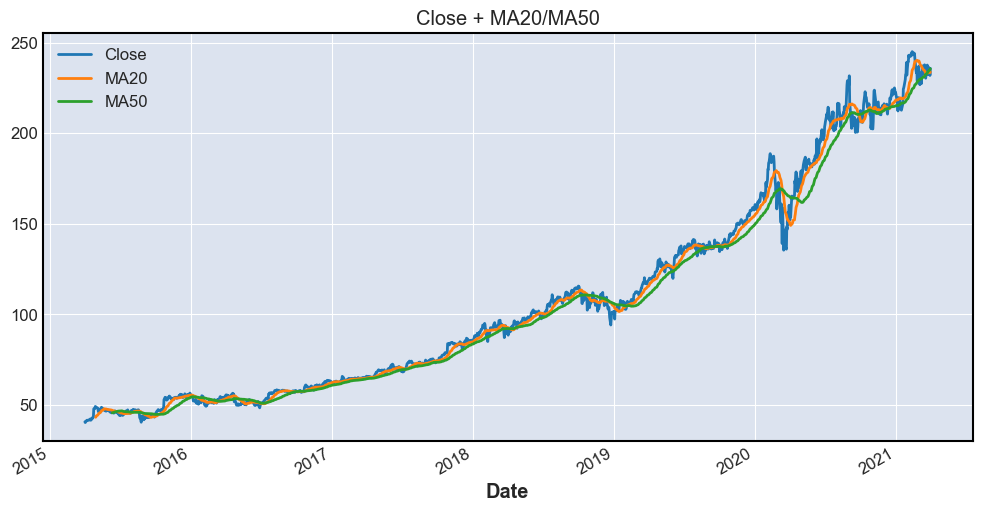

In [23]:
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()

# plot and save to PNG in images/
ax = df[['Close','MA20','MA50']].plot(figsize=(12,6), title="Close + MA20/MA50")
ax.get_figure().savefig('images/close_ma20_ma50.png', dpi=300, bbox_inches='tight')

#### Observations

When I overlay the 20- and 50-day moving averages on the closing price, I see that MA20 reacts quickly to short-term swings while MA50 lags and smooths out noise. Their crossovers tend to line up with trend reversals (for example around the March 2020 drop and rebound). Instead of using all three series directly, I’ll derive a single momentum feature (e.g. MA20 − MA50) to capture those shifts without introducing collinearity.

### Daily Returns Histogram

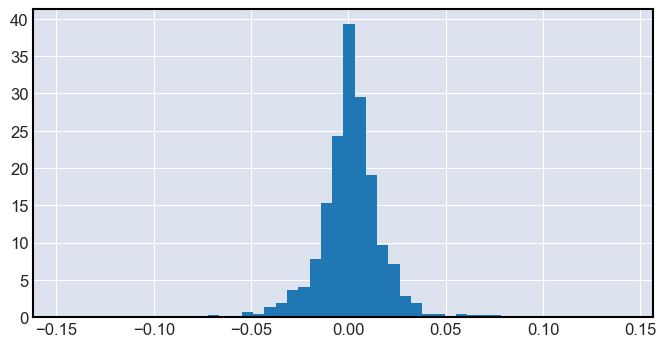

In [24]:
df['Ret'] = df['Close'].pct_change()

# plot the histogram and save to PNG in images/
ax = df['Ret'].hist(bins=50, figsize=(8,4), density=True)
ax.get_figure().savefig('images/returns_daily_histogram.png', dpi=300, bbox_inches='tight')

#### Observations

The return distribution is leptokurtic (fat tails) with a slight negative skew—there are more extreme negative returns than a normal curve would predict. If I blindly assume Gaussian errors, I’ll understate tail risk. Next step: I plan to explore GARCH‐type models with t-distributed (or skewed) innovations, or perhaps even a quantile‐regression approach to better capture extreme moves.

### Rolling volatility (standard deviation)

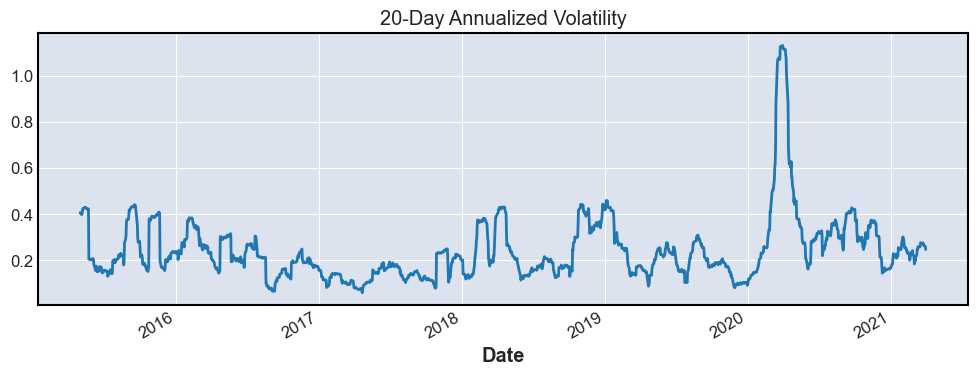

In [25]:
df['Vol20'] = df['Ret'].rolling(20).std() * np.sqrt(252)

# plot and save to PNG in images/
ax = df['Vol20'].plot(figsize=(12,4), title="20-Day Annualized Volatility")
ax.get_figure().savefig('images/20_day_annualized_volatility.png', dpi=300, bbox_inches='tight')

#### Observations

The rolling-window volatility shows classic clustering: long quiet spells interspersed with sudden spikes (again, March 2020 being the most extreme). This pattern confirms that a constant‐variance model is inadequate. Next step: I’ll implement an ARCH/GARCH family model (maybe starting with GARCH(1,1) and then moving to GJR‐GARCH or EGARCH) to explicitly capture this conditional heteroskedasticity.

### Scatter plot: returns vs. volume

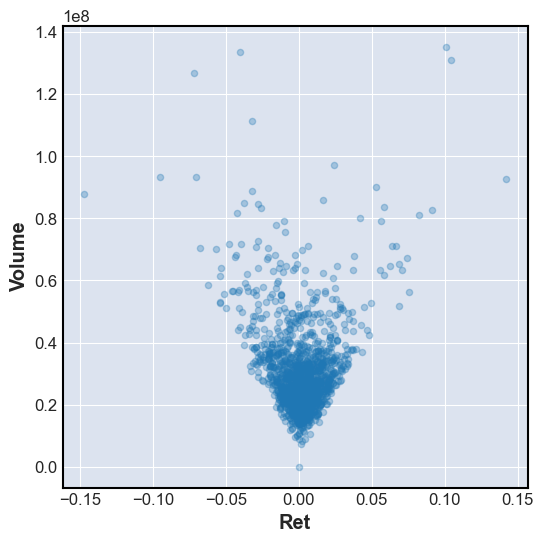

In [26]:
# plot scatter and save to PNG in images/
ax = df.plot.scatter(x='Ret', y='Volume', alpha=0.3, figsize=(6,6))
ax.get_figure().savefig('images/ret_vs_volume_scatter.png', dpi=300, bbox_inches='tight')

#### Observations

The scatter of daily returns against volume reveals a loose funnel pattern: large absolute returns tend to occur on higher volume days. There’s only a weak linear correlation, but the concentration of small returns at low volume is clear. Next step: I might engineer a feature like “high-volume day” dummy or use volume lagged by one day as a predictor in my volatility or return model.

### Correlation Heatmap

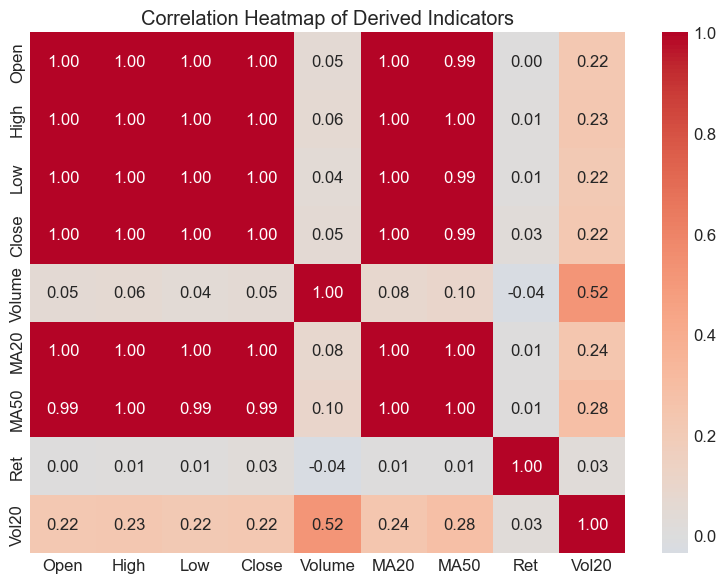

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute and plot
corr = df.corr()

# plot and save to PNG in images/
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Derived Indicators')
plt.tight_layout()
plt.savefig('images/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


#### Observations

As expected, the raw price series (Open/High/Low/Close) and the moving averages are almost perfectly collinear (ρ≈1), while returns are essentially uncorrelated with price levels. Volatility has only modest correlation with returns. Next step: I’ll drop redundant series—probably keep just Close and one moving average indicator (e.g. MA20). More importantly, I’ll build my models on returns (which are de-correlated) rather than raw prices.

### Monthly Box Plot

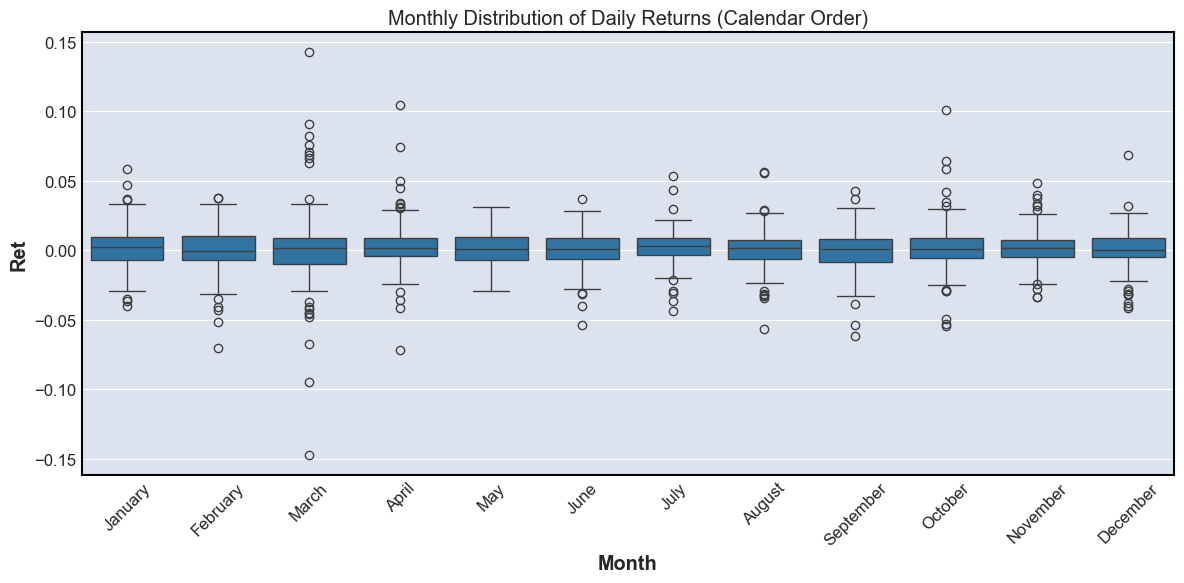

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# define calendar order
month_order = list(calendar.month_name)[1:]  # ['January', 'February', ..., 'December']

# convert to ordered categorical so seaborn respects it
df['Month'] = pd.Categorical(df.index.month_name(),
                             categories=month_order,
                             ordered=True)

plt.figure(figsize=(12,6))
sns.boxplot(x='Month', y='Ret', data=df, order=month_order)
plt.title('Monthly Distribution of Daily Returns (Calendar Order)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('images/boxplot_monthly.png', dpi=300, bbox_inches='tight')
plt.show()

#### Observations

Breaking returns down by month shows slightly higher dispersion in months like March and October, hinting at calendar effects. If I ignore these, my residuals may exhibit seasonality. Next step: I’ll test for significant monthly dummy effects and, if confirmed, include them in a regression framework or encode periodic seasonal terms in a SARIMAX model.

### Yearly Box Plot

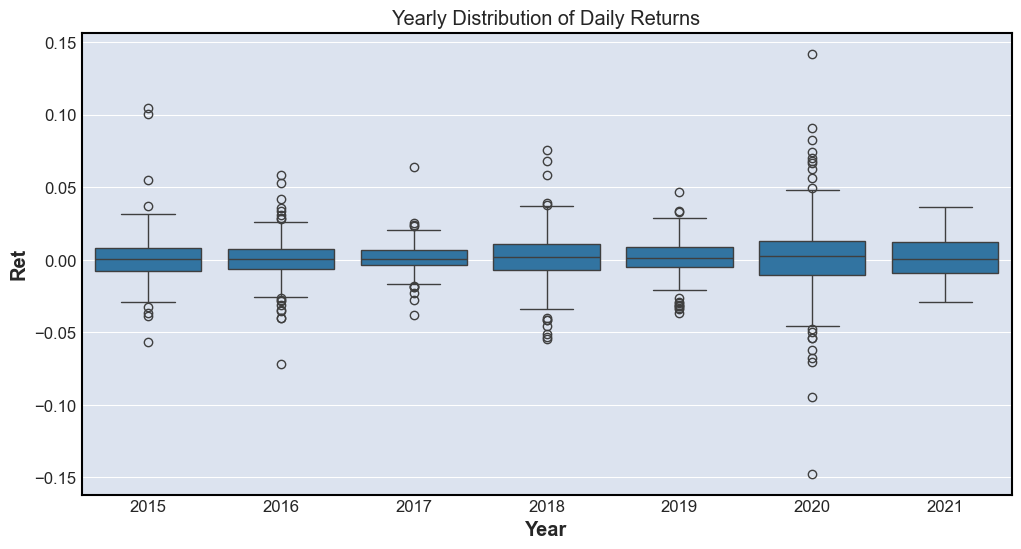

In [29]:
# Yearly boxplot
df['Year'] = df.index.year
plt.figure(figsize=(12,6))
sns.boxplot(x='Year', y='Ret', data=df)
plt.title('Yearly Distribution of Daily Returns')
plt.savefig('images/boxplot_yearly.png', dpi=300, bbox_inches='tight')
plt.show()

#### Observations

Returns’ variability clearly shifts year-to-year: 2018–2020 look much more volatile than earlier years. This suggests structural breaks or evolving market dynamics. Next step: I’ll consider either rolling-window estimation (refitting my model periodically) or a regime-switching approach to let parameters adjust over time.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Open    1511 non-null   float64 
 1   High    1511 non-null   float64 
 2   Low     1511 non-null   float64 
 3   Close   1511 non-null   float64 
 4   Volume  1511 non-null   int64   
 5   MA20    1492 non-null   float64 
 6   MA50    1462 non-null   float64 
 7   Ret     1510 non-null   float64 
 8   Vol20   1491 non-null   float64 
 9   Month   1511 non-null   category
 10  Year    1511 non-null   int32   
dtypes: category(1), float64(8), int32(1), int64(1)
memory usage: 125.8 KB


### Next-Step Modeling Plan

1. **Stationarity & Baseline**

   * Transform to **log-returns** and drop any NA rows.
   * Fit a simple **ARIMA** on returns as my baseline.

2. **Volatility Modeling**

   * Fit **GARCH(1,1)** with Student-t errors.
   * Compare against **EGARCH** or **GJR-GARCH** to capture leverage effects.

3. **Volume as Regressor**

   * Build a **VARX** including returns and volume.
   * Test **threshold GARCH** where a volume cutoff triggers a high-volatility regime.

4. **Calendar Effects**

   * Augment ARIMA/SARIMAX with **monthly dummy** exogenous variables.
   * Evaluate if these dummies improve forecast accuracy.

5. **Regime-Switching**

   * Explore a **Markov-switching model** on returns (or on volatility) to let parameters shift between “calm” and “turbulent” states.

6. **Model Comparison**

   * Backtest each approach on a hold-out period (e.g. 2019–2021), comparing **forecast RMSE** for returns and **volatility prediction loss**.

This roadmap ensures I leverage each insight—from non-stationarity and fat tails to volume signals and calendar effects—when choosing and tuning my time-series models.


# <span style="color:#5E6997">Predict Microsoft Stock</span> <a class="anchor" id="predict"></a>

### ARIMA Base Model

In [34]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# suppress all warnings (no need to reference undefined ValueWarning)
warnings.filterwarnings("ignore")

# 1. Compute log‐returns and drop the first NaN
returns = np.log(df['Close']).diff().dropna()

# 2. Fit a simple ARIMA(1,0,1) on the log‐returns
model = ARIMA(returns, order=(1, 0, 1))
baseline_fit = model.fit()

# 3. View the summary
print(baseline_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1508
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4007.712
Date:                Sun, 20 Jul 2025   AIC                          -8007.424
Time:                        21:26:19   BIC                          -7986.150
Sample:                             0   HQIC                         -7999.501
                               - 1508                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      3.136      0.002       0.000       0.002
ar.L1         -0.1862      0.059     -3.176      0.001      -0.301      -0.071
ma.L1         -0.0405      0.063     -0.642      0.5

#### ARIMA Results

The output shows:

* Jarque–Bera: strongly rejects normality (JB p≈0), which we knew from the fat tails in your histogram.

* Heteroskedasticity (H): test p≈0, confirming you need a volatility model (e.g. GARCH).

* Ljung–Box Q: very high p (≈1) at lag 1, which suggests no remaining autocorrelation in the residuals—good for your ARIMA baseline.

# <span style="color:#5E6997">Conclusion</span> <a class="anchor" id="conclusion"></a>